# This notebook is to Implement my solution for the home assignment
* Written by: Yotam Dery
* Submission date: 05/16/2024

## Imports

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
from utils import aggregate_duplicates, perform_adf_test_all_features
from plot_utils import plot_feature_over_time, plot_combined_trends, plot_corr, box_plot, plot_seasonal_decomposition, plot_lag_plots, plot_acf_plots, plot_pacf_plots, plot_mean_std_plots, create_pred_observed_plot

warnings.filterwarnings('ignore')

## EDA

### Reading the data file

In [3]:
# Reading and showing glimps of the data
df = pd.read_csv('lightricks_interview_dataset.csv', parse_dates=['month'])
df.tail(15)

,month,spend,revenue,subs
45,2024-01-01,78245.433186,228361.488025,42807.797696
46,2024-01-01,79194.849350,228361.488025,42807.797696
47,2024-02-01,72942.356713,NaN,NaN
48,2024-02-01,68365.845848,NaN,NaN
49,2024-03-01,84123.965592,NaN,NaN
50,2024-03-01,76110.299450,NaN,NaN
51,2024-04-01,78180.634086,NaN,NaN
52,2024-05-01,86814.089306,NaN,NaN
53,2024-06-01,87459.192145,NaN,NaN
54,2024-07-01,86602.082479,NaN,NaN


In [4]:
# As I noticed that there are rows which are duplicated by their month value - we handle it in this function
aggregated_df = aggregate_duplicates(df)

In [5]:
# Check for missing values
print(aggregated_df.isnull().sum())
print("\nrevenue and the number of subscribers is not known ahead of time. Hence, These null values are O.K.")

month       0
spend       0
revenue    11
subs       11
dtype: int64

revenue and the number of subscribers is not known ahead of time. Hence, These null values are O.K.


In [6]:
aggregated_df.describe()

,spend,revenue,subs
count,45.000000,34.000000,34.000000
mean,76008.017483,189175.002446,43183.683014
std,15068.365802,58885.541838,11815.383900
min,53974.044782,102986.770996,21775.164505
25%,68682.142098,141739.270826,33865.645563
50%,73281.546183,177698.244333,43103.881024
75%,80117.132521,237638.505176,52467.379499
max,138713.913887,304535.260688,65055.140810


In [7]:
aggregated_df.dtypes

month      datetime64[ns]
spend             float64
revenue           float64
subs              float64
dtype: object

### Plot time series plots

In [8]:
for feature in aggregated_df.select_dtypes(include='number'):
    plot_feature_over_time(aggregated_df, feature)

In [9]:
# Create traces
plot_combined_trends(aggregated_df)

### Correlation Analysis

In [10]:
correlation_matrix = np.round(aggregated_df.corr(),2)
plot_corr(correlation_matrix)
print("As observed from the time series plots and confirmed by the correlation analysis,\nthe features revenue and subscriptions are highly correlated.")

As observed from the time series plots and confirmed by the correlation analysis,
the features revenue and subscriptions are highly correlated.


### Box Plot

In [11]:
for feature in aggregated_df.select_dtypes(include='number'):
    box_plot(aggregated_df, feature)
print("As we can see, there are no outliers according to the box plot.\nThe boxes are fairly even")

As we can see, there are no outliers according to the box plot.
The boxes are fairly even


### Seasonal Decomposition

* Seasonal decomposition is a technique used in time series analysis to decompose a time series into several components, each representing an underlying pattern.<br> It helps in understanding and analyzing the structure of the time series data by separating it into more interpretable elements.<br> The main components in seasonal decomposition are:<br>
1. Trend Component:<br> This captures the long-term progression of the time series data. It represents the overall direction (upward or downward) in the data over a long period.<br><br>

2. Seasonal Component:<br> This captures the repeating short-term cycle in the data. For example, monthly sales data may have a seasonal component that reflects higher sales in certain months each year. <br><br>

3. Residual (or Irregular) Component:<br> This captures the random noise or irregular fluctuations in the data that cannot be explained by the trend or seasonal components. It's essentially the remaining part of the time series after removing the trend and seasonal effects.<br><br>

When applying this method, we'll use an Additive Model, Assuming that the time series is composed of the sum of its components: <br>
`Y(t)=T(t)+S(t)+R(t)`


In [12]:
# Set 'month' as index
aggregated_df.dropna(inplace=True)
aggregated_df.set_index('month', inplace=True)

In [13]:
for feature in aggregated_df.select_dtypes(include='number'):
    # Perform seasonal decomposition
    result = seasonal_decompose(aggregated_df[feature], model='additive', period=12)
    plot_seasonal_decomposition(result, aggregated_df, feature)

We can clearly draw some interesting insights from these plots: <br><br>
* Seasonality:<br>
    1. For Spend and Revenue, we can see that there are peaks every year around the summer of each year (May-October), and lows in the other months. <br> 
    2. For subscribers, the seasonality is much more narrow, peaking arround August each year, with lows in the winter (lowest at Feb.) <br><br>
* Residual: <br>
    The residual plot shows the residual component, which represents the random noise or irregular fluctuations in the data.<br>
    For all metrics, the residuals fluctuate around zero, indicating the presence of random variations not explained by the trend or seasonal components. <br> Some periods show higher residuals (positive or negative), suggesting occasional unexpected increases or decreases in spend that are not part of the regular pattern.
    

### Lag plots
* The lag plot is used to identify the presence of autocorrelation in a time series dataset. It plots each data point 
`y(t)` against the next data point `y(t+1)`.<br> High autocorrelation can indicate non-stationarity. 

In [14]:
for feature in df.select_dtypes(include='number'):
    plot_lag_plots(aggregated_df, feature, lag=1)

* Insights: <br><br>
1. Positive Autocorrelation: Spend shows a positive autocorrelation, with similar values tending to follow each other.<br> This metric is higher in Revenue and Subscribers features<br><br>
2. Variability: There is variability in spend, but a clustering around certain values suggests some level of stability or common spend ranges.<br>

In [15]:
for feature in df.select_dtypes(include='number'):
    plot_lag_plots(aggregated_df, feature, lag=12)

* Insights: <br><br>
1. Positive Autocorrelation: Taking a lag period of 12, Revenue shows a weak autocorrelation, while the other features show no autocorrelation.<br><br>
2. Variability: There is high variability in all features. This Implies on a low level of predictability.

### ACF Plots

In [16]:
for feature in df.select_dtypes(include='number'):
    plot_acf_plots(aggregated_df, feature)

* <b>General observations</b><br>
1. Stationarity: All three series ('spend', 'revenue', and 'subs') show signs of non-stationarity due to significant autocorrelations at initial lags. This non-stationarity could be due to trends or persistence in the data. <br>
2. To achieve stationarity, differencing the time series data is recommended. This involves subtracting the previous observation from the current observation to remove trends and stabilize the mean.<br>
3. The significant autocorrelations suggest that ARIMA models could be suitable for forecasting these time series. The AR (AutoRegressive) component of the model will help capture the persistence seen in the data.

### PACF Plots

In [17]:
for feature in df.select_dtypes(include='number'):
    plot_pacf_plots(aggregated_df, feature)

### Rolling Mean and Standard Deviation Plot

In [18]:
plot_mean_std_plots(aggregated_df, window_size=12)

* Insights and Strategic Implications: <br><br>
1. Sustained Growth: The steady increase in revenue and subscriptions indicates strong overall business performance, driven by effective strategies in acquiring and retaining customers.<br>
2. Predictability and Stability: Low and stable variability in both revenue and subscriptions, coupled with controlled spending, indicates a predictable and stable business environment, which is beneficial for long-term planning and forecasting.<br>
3. Balanced Approach: The data reflects a balanced approach where initial investments (higher spend) were made to drive growth (increased subscriptions and revenue), followed by a phase of optimized spending to maintain sustainable growth.<br>
4. The presence of a trend in the rolling mean and variations in the rolling standard deviation suggest that the features data is non-stationary (futher investigation should be conducted on that manner).

#### Performing ADF test for stationarity check

In [19]:
# Perform ADF test on the each features' data
perform_adf_test_all_features(aggregated_df, aggregated_df.select_dtypes(include='number'))

ADF test results:

Test results for feature: Spend
Used lag: 1
ADF Statistic: -4.862993591691974
p-value: 4.1144488726076716e-05
The time series is stationary.
##########################################


Test results for feature: Revenue
Used lag: 5
ADF Statistic: -0.7384520974658513
p-value: 0.8365366421484501
The time series is non-stationary.
##########################################


Test results for feature: Subs
Used lag: 0
ADF Statistic: -1.9985458298241614
p-value: 0.2872110658934871
The time series is non-stationary.
##########################################



* Not all data is stationary. Let's us diff on the data and test for stationarity again:

In [20]:
# Calculating the diff
for feature in aggregated_df.select_dtypes(include='number'):
    aggregated_df[feature+'_diff'] = aggregated_df[feature].diff()

aggregated_df.dropna(inplace=True)
aggregated_df.reset_index(inplace=True)

In [21]:
# Creating a list containing only the diff features
diff_features_list = []
for feature in aggregated_df.select_dtypes(include='number'):
    if '_diff' in feature:
        diff_features_list.append(feature)

# Plotting the diff features
for feature in diff_features_list:
    plot_feature_over_time(aggregated_df, feature)

In [22]:
# Perform ADF test on the each features' data
perform_adf_test_all_features(aggregated_df, diff_features_list)

ADF test results:

Test results for feature: Spend_diff
Used lag: 2
ADF Statistic: -4.1994660251091105
p-value: 0.0006602728975336425
The time series is stationary.
##########################################


Test results for feature: Revenue_diff
Used lag: 3
ADF Statistic: -4.04671125944463
p-value: 0.0011847300641754607
The time series is stationary.
##########################################


Test results for feature: Subs_diff
Used lag: 0
ADF Statistic: -6.33902514597515
p-value: 2.7842565680743006e-08
The time series is stationary.
##########################################



* Looking at the recent plots and the test above, it seems like our data after differencing is stationary!

## Model Development

### Choosing a predictive model

### Justification for Model Choice and Approach

** Chosen Models **: SARIMA (Seasonal AutoRegressive Integrated Moving Average) & SARIMAX (SARIMA with exogenous variables). We'll try these two models, and see if the exogenous variable enhancement improves our predictions.

**Reasoning**:
1. **Seasonality**: The data exhibits a clear seasonal pattern, with repeating cycles every 12 months. This is evident from the seasonal decomposition plot, which shows a strong seasonal component. SARIMA is well-suited for capturing such seasonal patterns, as it includes parameters specifically designed to model seasonality (P, D, Q, and s).

2. **Trend**: The trend component in the seasonal decomposition plot indicates a persistent upward trend over time. Differencing the series (d = 1) helps in making the series stationary by removing this trend, which is a crucial step for time series forecasting models like SARIMA.

3. **Autocorrelation and Partial Autocorrelation**:
   - **PACF Plot**: A significant spike at lag 1, which leads to a steep cutoff at lag 1, suggests an autoregressive component. Thus, the autoregressive order (p) was set to 1.
   - **ACF Plot**: If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms. This implies that maybe we should set MA to 0. <br> We'll use MA=1 to see a little bit of its signiture.

4. **Exogenous Variables**: The SARIMA model was extended to SARIMAX to include exogenous variable `spend`. This allows the model to account for external factors influencing revenue.<br> As the model's structure assumes that it has access to the future of the exogenous variable, we can not use `subs` as an exogenous variable. <br> We could predict this variable and use the output as an exogenous varibale, but this kind of attempt to predict 2 things at once may propegate an immense error and given our data, is not reliable.<br> 

5. **Differencing**:
   - **We set d = 1 and D =1 As per our ADF test results: all data turned to be stationary when using a differencing of 1**

**Alternative Models Considered**:
- **ARIMA**: Not chosen because it doesn't explicitly model seasonality, which is a prominent feature in the data.
- **Exponential Smoothing (ETS)**: Suitable for capturing trends and seasonality but doesn't handle exogenous variables as effectively as SARIMAX.
- **LSTM/GRU**: Neural network models could capture complex patterns, but they require more data and computational resources. SARIMAX is more interpretable and efficient for this dataset.
- **Random Forest/XGBoost**: These models handle non-linear relationships well but are not specifically designed for time series data with seasonality.

**Conclusion**:
The SARIMA model, extended to SARIMAX, was chosen for its robustness in handling seasonality, trends, and external influences through exogenous variables. This choice ensures a comprehensive and accurate forecast of revenue, leveraging the strengths of the model to address the specific characteristics of the data.

This justification incorporates the detailed examination of the plots and the data characteristics as observed in the notebook and the provided plots.

#### SARIMA model

- ** Performing Grid Search using AutoARIMA **<br>
It is highly recommended not to rely only on the human eye, but elso let the computer do the work for us. <br> 
Hence, we'll use an automatic way to find the "best parameters" for our model, alongside to our manual settings, and choose the best option

In [23]:
df = aggregate_duplicates(df)
df.set_index('month', inplace=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30783D+00    |proj g|=  4.72192D-01

At iterate    5    f=  4.11868D+00    |proj g|=  2.45204D-02

At iterate   10    f=  4.11131D+00    |proj g|=  2.89646D-03

At iterate   15    f=  4.11116D+00    |proj g|=  1.05836D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   1.430D-05   4.111D+00
  F =   4.1111598597914778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Manual M

 This problem is unconstrained.


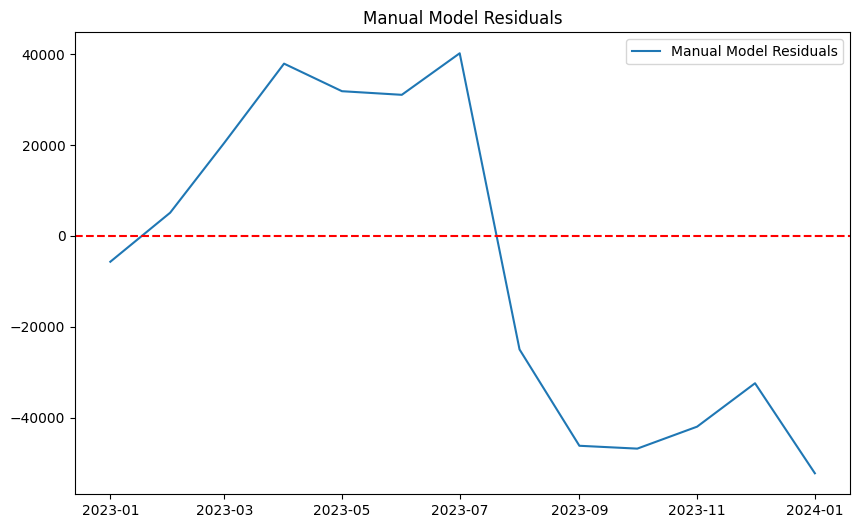

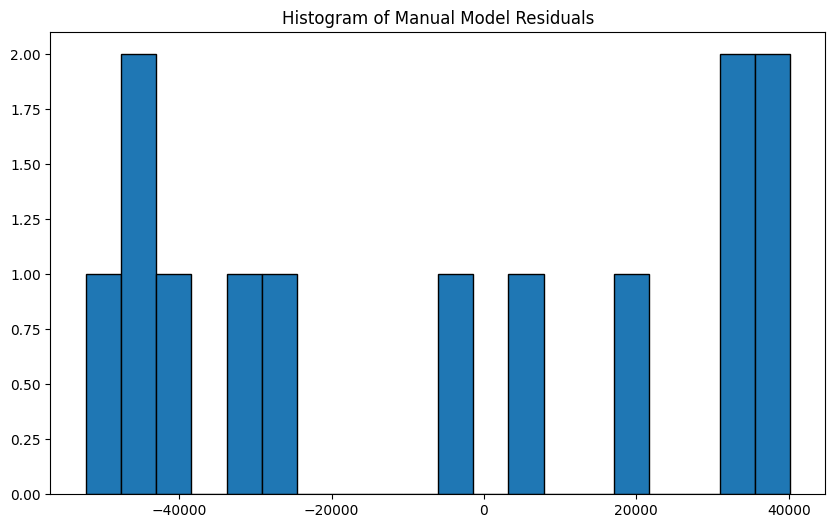

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=182.758, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=181.297, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=181.125, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=183.001, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=182.814, Time=0.15 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=183.297, Time=0.12 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=184.689, Time=0.26 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=184.805, Time=0.32 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=185.001, Time=0.17 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=186.805, Time=0.27 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=185.297, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=183.425, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=182.029, Time=0.07 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=187.001, Time=0.28 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=186.689, Time=0.68 sec
 ARIMA(0,1

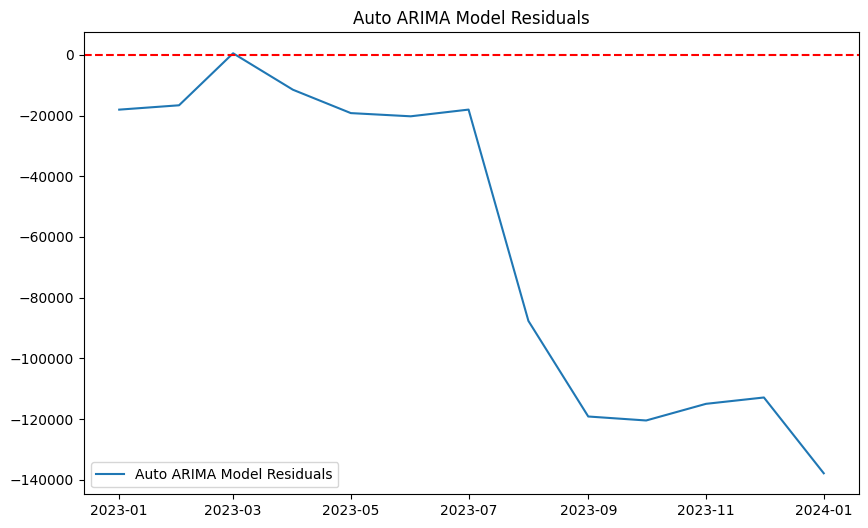

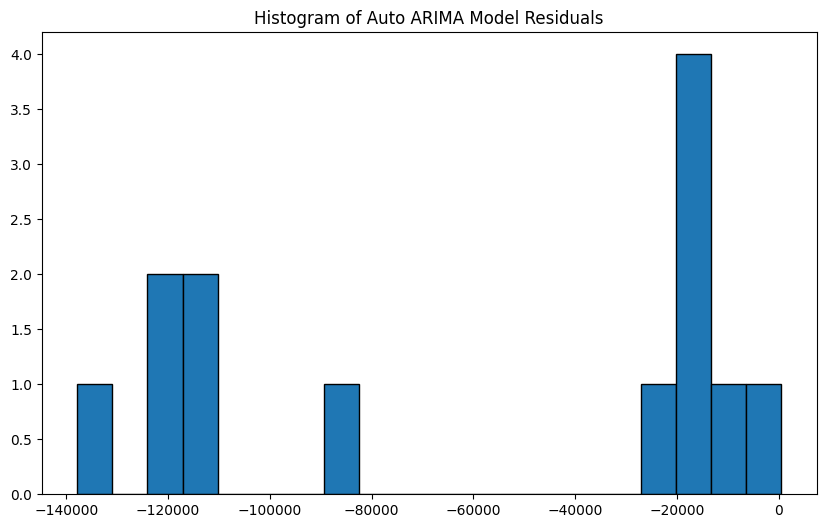

Comparison of Metrics:
Manual Model - MAE: 32083.289235076034 | Auto ARIMA Model - MAE: 61332.402624791095
Manual Model - MSE: 1232017414.0233395 | Auto ARIMA Model - MSE: 6403219791.390024
Manual Model - RMSE: 35100.105612709194 | Auto ARIMA Model - RMSE: 80020.12116580445
Manual Model - MAPE: 12.521549160162184% | Auto ARIMA Model - MAPE: 24.662465071484224%


In [24]:
df_sarima_dev = df.copy().dropna()

# Split the data into training and test sets
train_size = 21
train = df_sarima_dev['revenue'].iloc[:train_size]
test = df_sarima_dev['revenue'].iloc[train_size:]

# Fit the manually chosen SARIMA model
manual_model = sm.tsa.SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
manual_results = manual_model.fit()

# Forecast using the manually chosen model
start = len(train)
end = len(train) + len(test) - 1
predictions = manual_results.predict(start=start, end=end, dynamic=False)

# Calculate metrics for the manually chosen model
manual_mae = mean_absolute_error(test, predictions)
manual_mse = mean_squared_error(test, predictions)
manual_rmse = np.sqrt(manual_mse)
manual_mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f'Manual Model - MAE: {manual_mae}')
print(f'Manual Model - MSE: {manual_mse}')
print(f'Manual Model - RMSE: {manual_rmse}')
print(f'Manual Model - MAPE: {manual_mape}%')

# Residual analysis for the manually chosen model
manual_residuals = test - predictions

# Plot residuals for the manually chosen model
plt.figure(figsize=(10, 6))
plt.plot(manual_residuals, label='Manual Model Residuals')
plt.axhline(0, linestyle='--', color='r')
plt.title('Manual Model Residuals')
plt.legend()
plt.show()

# Plot histogram of residuals for the manually chosen model
plt.figure(figsize=(10, 6))
plt.hist(manual_residuals, bins=20, edgecolor='k')
plt.title('Histogram of Manual Model Residuals')
plt.show()

# Use auto_arima to find the best parameters
auto_model = auto_arima(train,
                        seasonal=True,
                        m=12,
                        start_p=0, max_p=3,
                        start_q=0, max_q=3,
                        d=1,
                        start_P=0, max_P=3,
                        start_Q=0, max_Q=3,
                        D=1,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=False,  # Disable stepwise algorithm for exhaustive search
                        n_jobs=-1,       # Use all available cores
                        information_criterion='aic')  # Can be 'aic', 'bic', or 'hqic'

# Print auto_arima model summary
print(auto_model.summary())

# Forecast using the auto_arima model
auto_forecast = auto_model.predict(n_periods=len(test))

# Calculate metrics for the auto_arima model
auto_mae = mean_absolute_error(test, auto_forecast)
auto_mse = mean_squared_error(test, auto_forecast)
auto_rmse = np.sqrt(auto_mse)
auto_mape = np.mean(np.abs((test - auto_forecast) / test)) * 100

print(f'Auto ARIMA Model - MAE: {auto_mae}')
print(f'Auto ARIMA Model - MSE: {auto_mse}')
print(f'Auto ARIMA Model - RMSE: {auto_rmse}')
print(f'Auto ARIMA Model - MAPE: {auto_mape}%')

# Residual analysis for the auto_arima model
auto_residuals = test - auto_forecast

# Plot residuals for the auto_arima model
plt.figure(figsize=(10, 6))
plt.plot(auto_residuals, label='Auto ARIMA Model Residuals')
plt.axhline(0, linestyle='--', color='r')
plt.title('Auto ARIMA Model Residuals')
plt.legend()
plt.show()

# Plot histogram of residuals for the auto_arima model
plt.figure(figsize=(10, 6))
plt.hist(auto_residuals, bins=20, edgecolor='k')
plt.title('Histogram of Auto ARIMA Model Residuals')
plt.show()

# Compare metrics of both models
print("Comparison of Metrics:")
print(f'Manual Model - MAE: {manual_mae} | Auto ARIMA Model - MAE: {auto_mae}')
print(f'Manual Model - MSE: {manual_mse} | Auto ARIMA Model - MSE: {auto_mse}')
print(f'Manual Model - RMSE: {manual_rmse} | Auto ARIMA Model - RMSE: {auto_rmse}')
print(f'Manual Model - MAPE: {manual_mape}% | Auto ARIMA Model - MAPE: {auto_mape}%')


* The results from the auto_arima are slightly better let's use these for the evaluation part for the SARIMA model!

### Model evaluation - SARIMA
* Let's perform the model evaluation with the chosen parameters

In [25]:
# Time series cross-validation
import plotly.graph_objs as go
from plotly.subplots import make_subplots

df_sarima_eval = df.copy().dropna()

# Define the endogenous variable (revenue_diff) and exogenous variables (spend_diff and subs_diff)
endog = df_sarima_eval['revenue']

# Parameters based on auto_arima results - "Best model:  ARIMA(0,1,2)(1,1,0)[12]"
p, d, q = 0, 1, 2
P, D, Q, s = 1, 1, 0, 12

# Define the number of splits for rolling window cross-validation
n_splits = 2

# Initialize lists to store metrics
mae_list, mse_list, rmse_list, mape_list = [], [], [], []

# Rolling window cross-validation
split_size = int(len(df_sarima_eval) / (n_splits + 1))

for i in range(n_splits):
    train_end = split_size * (i + 1)
    test_end = train_end + split_size

    train_endog = endog[:train_end]
    test_endog = endog[train_end:test_end]

    # Fit the SARIMA model
    model = sm.tsa.SARIMAX(train_endog, order=(p, d, q), seasonal_order=(P, D, Q, s), type='levels')
    results = model.fit()

    # Forecast on the test set
    forecast_steps = len(test_endog)
    forecast = results.get_forecast(steps=forecast_steps)
    forecasted_values = forecast.predicted_mean

    # Calculate metrics
    mae = mean_absolute_error(test_endog, forecasted_values)
    mse = mean_squared_error(test_endog, forecasted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_endog - forecasted_values) / test_endog)) * 100

    # Append metrics to the lists
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    mape_list.append(mape)

    # Plot the results for the current fold using Plotly
    fig = make_subplots(rows=1, cols=1, subplot_titles=[f'Revenue Forecast (Fold {i+1})'])

    fig.add_trace(go.Scatter(x=train_endog.index, y=train_endog, mode='lines', name='Train Observed'), row=1, col=1)
    fig.add_trace(go.Scatter(x=test_endog.index, y=test_endog, mode='lines', name='Test Observed', line=dict(dash='dash')), row=1, col=1)
    fig.add_trace(go.Scatter(x=forecasted_values.index, y=forecasted_values, mode='lines', name='Forecasted', line=dict(color='red')), row=1, col=1)
    fig.add_trace(go.Scatter(x=forecasted_values.index, y=forecast.conf_int().iloc[:, 0], mode='lines', name='Lower CI', line=dict(color='pink')), row=1, col=1)
    fig.add_trace(go.Scatter(x=forecasted_values.index, y=forecast.conf_int().iloc[:, 1], mode='lines', name='Upper CI', fill='tonexty', fillcolor='rgba(255,182,193,0.2)', line=dict(color='pink')), row=1, col=1)

    fig.add_vline(x=test_endog.index[0], line=dict(color='gray', dash='dash'))

    fig.update_layout(title=f'Revenue Forecast (Fold {i+1})', xaxis_title='Month', yaxis_title='Revenue Difference', showlegend=True)
    fig.show()

# Calculate average metrics
avg_mae = np.mean(mae_list)
avg_mse = np.mean(mse_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)

print(f'Average MAE: {avg_mae}')
print(f'Average MSE: {avg_mse}')
print(f'Average RMSE: {avg_rmse}')
print(f'Average MAPE: {avg_mape}%')


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.93506D+00    |proj g|=  3.86857D+00

At iterate    5    f=  4.51990D+00    |proj g|=  4.03132D-01

At iterate   10    f=  4.48689D+00    |proj g|=  1.28411D-03

At iterate   15    f=  4.48689D+00    |proj g|=  6.95257D-04


 This problem is unconstrained.



At iterate   20    f=  4.48687D+00    |proj g|=  9.77142D-03

At iterate   25    f=  4.48397D+00    |proj g|=  1.01370D-01

At iterate   30    f=  4.40012D+00    |proj g|=  2.28830D-01

At iterate   35    f=  4.33486D+00    |proj g|=  6.39140D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     42      1     0     0   5.576D-06   4.335D+00
  F =   4.3348074954956921     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


Average MAE: 28849.868621653157
Average MSE: 993971321.6499698
Average RMSE: 31359.971237832135
Average MAPE: 13.925355799642215%


</b>Explanation </b>
- **Cross-Validation Setup**: The data is split into multiple train-test sets using a rolling window approach. <br>
- **Model Fitting and Forecasting**: For each train-test split, the SARIMA model is fitted on the training set and forecasts are made for the test set.<br>
- **Metrics Calculation**: Performance metrics (MAE, MSE, RMSE, MAPE) are calculated for each test set and averaged across all splits.<br>
- **Plotting**: The results of each fold are plotted using Plotly, showing the observed training and test data, along with the forecasted values and confidence intervals.<br>

#### SARIMAX model

** Performing Grid Search using AutoARIMA **

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.92820D+00    |proj g|=  2.15866D+00

At iterate    5    f=  4.06464D+00    |proj g|=  9.20383D-02

At iterate   10    f=  4.05456D+00    |proj g|=  3.28511D-02

At iterate   15    f=  4.05076D+00    |proj g|=  4.80215D-03

At iterate   20    f=  4.05064D+00    |proj g|=  9.32833D-04


 This problem is unconstrained.



At iterate   25    f=  4.05056D+00    |proj g|=  4.25005D-03

At iterate   30    f=  4.05056D+00    |proj g|=  1.00227D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     36      1     0     0   1.002D-05   4.051D+00
  F =   4.0505581011690825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Manual Model - MAE: 29302.88077456125
Manual Model - MSE: 1154834357.733855
Manual Model - RMSE: 33982.85387859376
Manual Model - MAPE: 11.185120641981273%


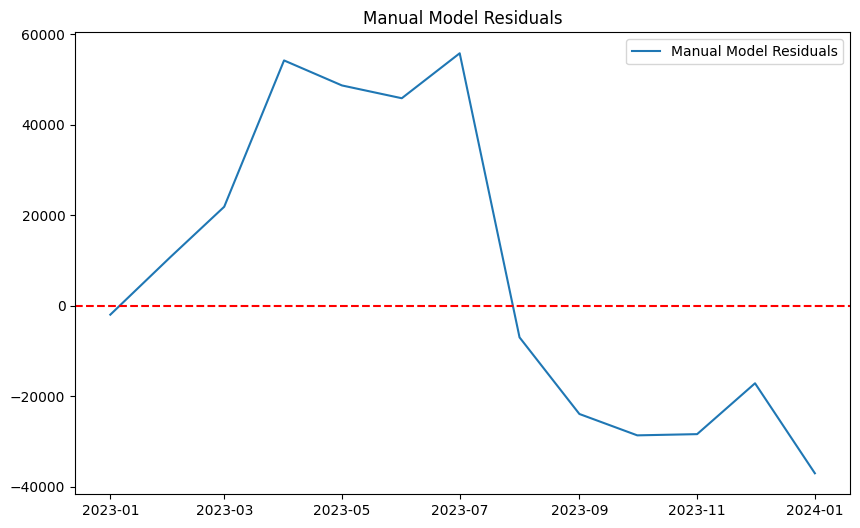

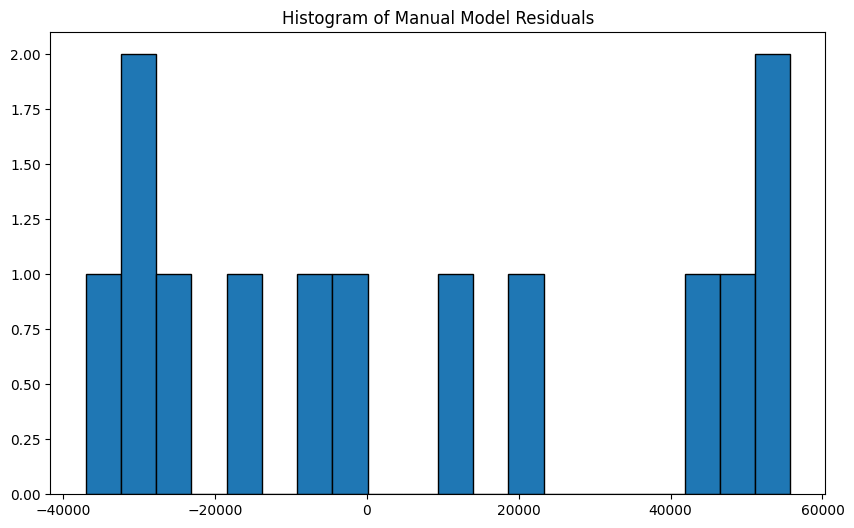

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=182.758, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=181.297, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=181.125, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=183.001, Time=0.13 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=182.814, Time=0.14 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=184.689, Time=0.29 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=183.297, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=184.805, Time=0.35 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=185.001, Time=0.21 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=185.297, Time=0.20 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=186.805, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=183.425, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=182.029, Time=0.07 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=186.689, Time=0.74 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=187.001, Time=0.28 sec
 ARIMA(0,1

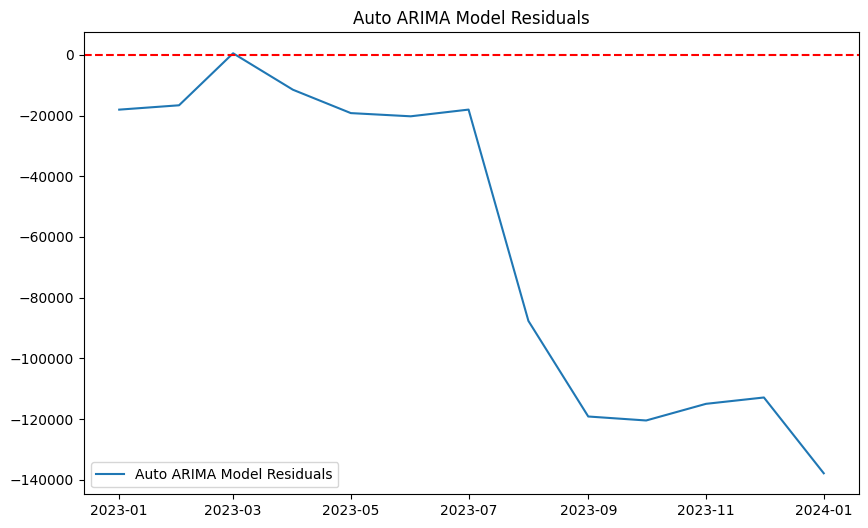

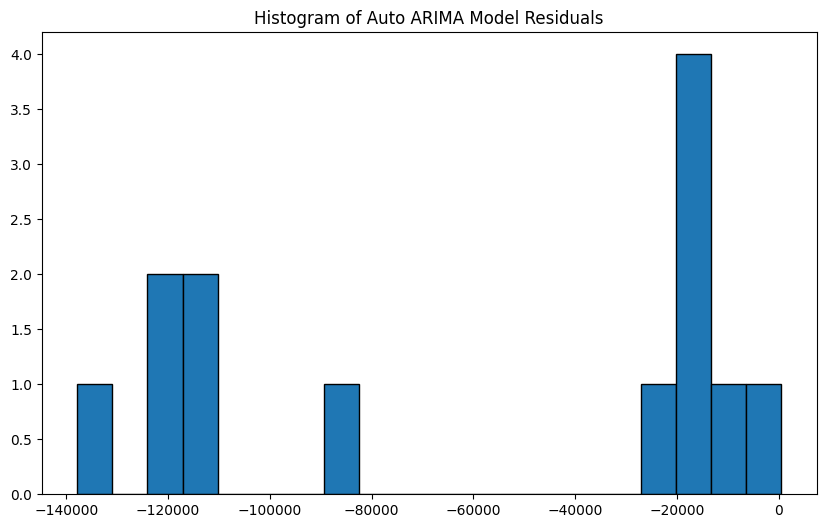

Comparison of Metrics:
Manual Model - MAE: 29302.88077456125 | Auto ARIMA Model - MAE: 61332.402624791095
Manual Model - MSE: 1154834357.733855 | Auto ARIMA Model - MSE: 6403219791.390024
Manual Model - RMSE: 33982.85387859376 | Auto ARIMA Model - RMSE: 80020.12116580445
Manual Model - MAPE: 11.185120641981273% | Auto ARIMA Model - MAPE: 24.662465071484224%


In [31]:
df_sarimax_dev = df.copy().dropna()

# Define the endogenous variable (revenue_diff) and exogenous variables (spend_diff and subs_diff)
endog = df_sarimax_dev['revenue']
exog = df_sarimax_dev[['spend']]

# Split the data into training and test sets
train_size = 21
train_endog = endog[:train_size]
test_endog = endog[train_size:]
train_exog = exog[:train_size]
test_exog = exog[train_size:]

# Fit the manually chosen SARIMA model
manual_model = sm.tsa.SARIMAX(train_endog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=train_exog)
manual_results = manual_model.fit()

# Forecast using the manually chosen model
manual_forecast = manual_results.get_forecast(steps=len(test_endog), exog=test_exog)
manual_forecasted_values = manual_forecast.predicted_mean

# Calculate metrics for the manually chosen model
manual_mae = mean_absolute_error(test_endog, manual_forecasted_values)
manual_mse = mean_squared_error(test_endog, manual_forecasted_values)
manual_rmse = np.sqrt(manual_mse)
manual_mape = np.mean(np.abs((test_endog - manual_forecasted_values) / test_endog)) * 100

print(f'Manual Model - MAE: {manual_mae}')
print(f'Manual Model - MSE: {manual_mse}')
print(f'Manual Model - RMSE: {manual_rmse}')
print(f'Manual Model - MAPE: {manual_mape}%')

# Residual analysis for the manually chosen model
manual_residuals = test_endog - manual_forecasted_values

# Plot residuals for the manually chosen model
plt.figure(figsize=(10, 6))
plt.plot(manual_residuals, label='Manual Model Residuals')
plt.axhline(0, linestyle='--', color='r')
plt.title('Manual Model Residuals')
plt.legend()
plt.show()

# Plot histogram of residuals for the manually chosen model
plt.figure(figsize=(10, 6))
plt.hist(manual_residuals, bins=20, edgecolor='k')
plt.title('Histogram of Manual Model Residuals')
plt.show()

# Use auto_arima to find the best parameters
auto_model = auto_arima(train_endog,
                        exogenous=train_exog,
                        seasonal=True,
                        m=12,
                        start_p=0, max_p=3,
                        start_q=0, max_q=3,
                        d=1,
                        start_P=0, max_P=3,
                        start_Q=0, max_Q=3,
                        D=1,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=False,  # Disable stepwise algorithm for exhaustive search
                        n_jobs=-1,       # Use all available cores
                        information_criterion='aic')  # Can be 'aic', 'bic', or 'hqic'

# Print auto_arima model summary
print(auto_model.summary())

# Forecast using the auto_arima model
auto_forecast = auto_model.predict(n_periods=len(test_endog), exogenous=test_exog)

# Calculate metrics for the auto_arima model
auto_mae = mean_absolute_error(test_endog, auto_forecast)
auto_mse = mean_squared_error(test_endog, auto_forecast)
auto_rmse = np.sqrt(auto_mse)
auto_mape = np.mean(np.abs((test_endog - auto_forecast) / test_endog)) * 100

print(f'Auto ARIMA Model - MAE: {auto_mae}')
print(f'Auto ARIMA Model - MSE: {auto_mse}')
print(f'Auto ARIMA Model - RMSE: {auto_rmse}')
print(f'Auto ARIMA Model - MAPE: {auto_mape}%')

# Residual analysis for the auto_arima model
auto_residuals = test_endog - auto_forecast

# Plot residuals for the auto_arima model
plt.figure(figsize=(10, 6))
plt.plot(auto_residuals, label='Auto ARIMA Model Residuals')
plt.axhline(0, linestyle='--', color='r')
plt.title('Auto ARIMA Model Residuals')
plt.legend()
plt.show()

# Plot histogram of residuals for the auto_arima model
plt.figure(figsize=(10, 6))
plt.hist(auto_residuals, bins=20, edgecolor='k')
plt.title('Histogram of Auto ARIMA Model Residuals')
plt.show()

# Compare metrics of both models
print("Comparison of Metrics:")
print(f'Manual Model - MAE: {manual_mae} | Auto ARIMA Model - MAE: {auto_mae}')
print(f'Manual Model - MSE: {manual_mse} | Auto ARIMA Model - MSE: {auto_mse}')
print(f'Manual Model - RMSE: {manual_rmse} | Auto ARIMA Model - RMSE: {auto_rmse}')
print(f'Manual Model - MAPE: {manual_mape}% | Auto ARIMA Model - MAPE: {auto_mape}%')


<b>Summary</b>

- **Comparison results**: As auto_arima method finds a slightly better set of parameters in terms of AIC, my manual chosen parameters are substentially better in terms of comparison metrics.<br> It confirms that my manual parameter selection is indeed more effective for this specific dataset.<br><br>
- **Interpertation for the manual parameters plots**:
- **Residuals Plot**: The residuals generally fluctuate around zero, showing no systematic bias, which is a positive indicator. Although there are some larger deviations, this highlights opportunities for further model refinement.
- **Histogram of Residuals**: The distribution of residuals highlights diverse patterns in the data, suggesting there are interesting nuances and potential areas for model enhancement.


### Model evaluation - SARIMAX
* Let's perform the model evaluation with the chosen parameters

In [33]:
# Time series cross-validation
import plotly.graph_objs as go
from plotly.subplots import make_subplots

df_sarimax_eval = df.copy().dropna()

# Define the endogenous variable (revenue_diff) and exogenous variables (spend_diff and subs_diff)
endog = df_sarimax_eval['revenue']
exog = df_sarimax_eval[['spend', 'subs']]

# Parameters based on ACF and PACF plots and seasonal decomposition
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

# Define the number of splits for rolling window cross-validation
n_splits = 2

# Initialize lists to store metrics
mae_list, mse_list, rmse_list, mape_list = [], [], [], []

# Rolling window cross-validation
split_size = int(len(endog) / (n_splits + 1))

for i in range(n_splits):
    train_end = split_size * (i + 1)
    test_end = train_end + split_size

    train_endog = endog[:train_end]
    test_endog = endog[train_end:test_end]
    train_exog = exog[:train_end]
    test_exog = exog[train_end:test_end]

    # Fit the SARIMA model
    model = sm.tsa.SARIMAX(train_endog, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=train_exog, type='levels')
    results = model.fit()

    # Forecast on the test set
    forecast_steps = len(test_endog)
    forecast = results.get_forecast(steps=forecast_steps, exog=test_exog)
    forecasted_values = forecast.predicted_mean

    # Calculate metrics
    mae = mean_absolute_error(test_endog, forecasted_values)
    mse = mean_squared_error(test_endog, forecasted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_endog - forecasted_values) / test_endog)) * 100

    # Append metrics to the lists
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    mape_list.append(mape)

    # Plot the results for the current fold using Plotly
    fig = make_subplots(rows=1, cols=1, subplot_titles=[f'Revenue Forecast (Fold {i+1})'])

    fig.add_trace(go.Scatter(x=train_endog.index, y=train_endog, mode='lines', name='Train Observed'), row=1, col=1)
    fig.add_trace(go.Scatter(x=test_endog.index, y=test_endog, mode='lines', name='Test Observed', line=dict(dash='dash')), row=1, col=1)
    fig.add_trace(go.Scatter(x=forecasted_values.index, y=forecasted_values, mode='lines', name='Forecasted', line=dict(color='red')), row=1, col=1)
    fig.add_trace(go.Scatter(x=forecasted_values.index, y=forecast.conf_int().iloc[:, 0], mode='lines', name='Lower CI', line=dict(color='pink')), row=1, col=1)
    fig.add_trace(go.Scatter(x=forecasted_values.index, y=forecast.conf_int().iloc[:, 1], mode='lines', name='Upper CI', fill='tonexty', fillcolor='rgba(255,182,193,0.2)', line=dict(color='pink')), row=1, col=1)

    fig.add_vline(x=test_endog.index[0], line=dict(color='gray', dash='dash'))

    fig.update_layout(title=f'Revenue Forecast (Fold {i+1})', xaxis_title='Month', yaxis_title='Revenue Difference', showlegend=True)
    fig.show()

# Calculate average metrics
avg_mae = np.mean(mae_list)
avg_mse = np.mean(mse_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)

print(f'Average MAE: {avg_mae}')
print(f'Average MSE: {avg_mse}')
print(f'Average RMSE: {avg_rmse}')
print(f'Average MAPE: {avg_mape}%')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14409D+00    |proj g|=  2.09872D+00


 This problem is unconstrained.



At iterate    5    f=  4.35409D+00    |proj g|=  7.14778D-02

At iterate   10    f=  4.33114D+00    |proj g|=  7.50021D-02

At iterate   15    f=  4.31466D+00    |proj g|=  2.64426D-02

At iterate   20    f=  4.31200D+00    |proj g|=  8.55261D-03

At iterate   25    f=  4.31129D+00    |proj g|=  2.87277D-03

At iterate   30    f=  4.31122D+00    |proj g|=  5.57622D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     32      1     0     0   4.622D-05   4.311D+00
  F =   4.3112167591458919     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Average MAE: 24703.574439153854
Average MSE: 922721982.8369186
Average RMSE: 30297.875866395327
Average MAPE: 12.173121116610432%


</b>Explanation </b>
- **Cross-Validation Setup**: The data is split into multiple train-test sets using a rolling window approach. <br>
- **Model Fitting and Forecasting**: For each train-test split, the SARIMA model is fitted on the training set and forecasts are made for the test set.<br>
- **Metrics Calculation**: Performance metrics (MAE, MSE, RMSE, MAPE) are calculated for each test set and averaged across all splits.<br>
- **Plotting**: The results of each fold are plotted using Plotly, showing the observed training and test data, along with the forecasted values and confidence intervals.<br>

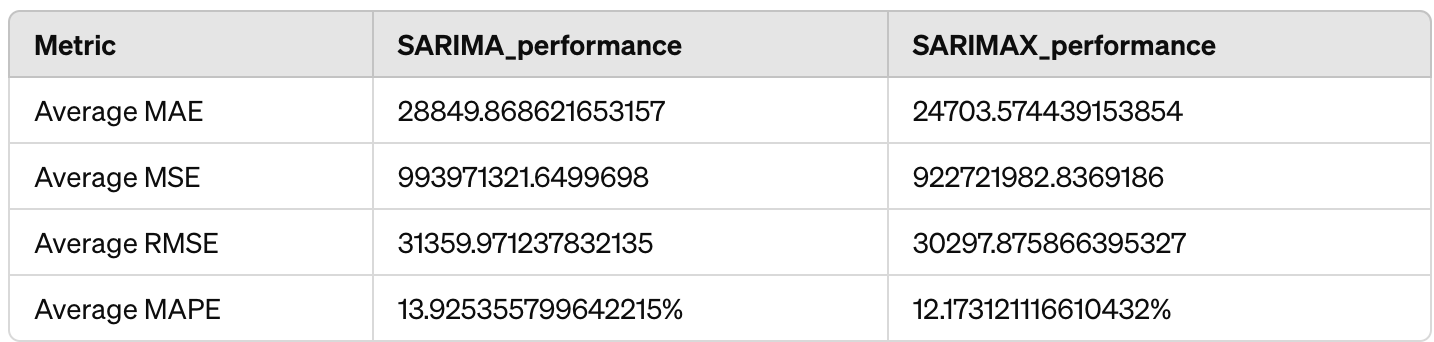

In [36]:
from IPython.display import Image

# Display the image
Image(filename='Performance_summary.png')

* Looks like the SARIMAX model is outperforming the SARIMA model!<br>Let's use it to predict the future revenue for 2024

### Predict into the future using the chosen model

In [37]:
# Define the endogenous variable (revenue_diff) and exogenous variables (spend_diff and subs_diff)
df_model_dev = df.copy()
endog = df_model_dev['revenue']
exog = df_model_dev[['spend']]

# Suggested parameters based on ACF and PACF plots
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

# Fit the SARIMA model
model = sm.tsa.SARIMAX(endog, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=exog)
results = model.fit()

# Print model summary
print(results.summary())

# Forecast future values
forecast_steps = 11  # Number of steps to forecast
exog_forecast = exog[-forecast_steps:]  # Use the last exog values for forecasting

forecast = results.get_forecast(steps=forecast_steps, exog=exog_forecast, dynamic=False)
forecasted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Align forecasted values with the appropriate dates
forecasted_values.index = df.index[-11:]
confidence_intervals.index = df.index[-11:]

create_pred_observed_plot(df, forecasted_values, confidence_intervals, forecast_steps)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43044D+00    |proj g|=  3.57515D-01

At iterate    5    f=  5.31110D+00    |proj g|=  1.49041D-02

At iterate   10    f=  5.30561D+00    |proj g|=  2.09721D-03

At iterate   15    f=  5.30529D+00    |proj g|=  4.56494D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     18      1     0     0   1.095D-05   5.305D+00
  F =   5.3052866468030802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

# THE END :)